In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy as sp

import pickle 

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':23}); plt.rcParams.update({'axes.linewidth':1.5}); plt.rc('axes', axisbelow=True);
plt.rc('lines',linewidth=3); plt.rcParams['axes.spines.right'] = False; plt.rcParams['axes.spines.top'] = False 
plt.rcParams['xtick.major.size'] = 8; plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 2; plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 8; plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.major.width'] = 2; plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'


import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR

from torch_geometric.nn import SGConv, GCNConv
from torch_geometric.data import Data

### Preprocessing RNA and Tn datasets
!!!: RNA data metadata cols don't match Tn data metadata cols

Don't need them to match exactly, but would prefer the same metadata for each modality

In [3]:
with open('2_PreprocessedData_RbTnSeq.pickle', 'rb') as handle:
    tn = pickle.load(handle)  

with open('2_PreprocessedData_RNASeq_OD.pickle', 'rb') as handle:
    rna = pickle.load(handle)  

Put the data in AnnData format

In [4]:
rna['X'] = rna['X'].T
rna['X'].index = rna['X'].index.astype(str)
rna['metadata'].index = rna['metadata'].index.astype(str)
rna['metadata'].reset_index(inplace=True,drop=True)

rnadata = sc.AnnData(rna['X'])
rnadata.obs = rna['metadata']

In [5]:
tn['X'] = tn['X'].T
tn['X'].index = tn['X'].index.astype(str)
tn['metadata'].index = tn['metadata'].index.astype(str)

tndata = sc.AnnData(tn['X'])
tndata.obs = tn['metadata']

Subset the genes to those in common between RNA and Tn

In [6]:
genes_in_common = list(set(rnadata.var_names).intersection(set(tndata.var_names)) )

# SUBSET TO ONLY 250 GENES TO MAKE MODEL SETUP EASIER
np.random.seed(0)

n_genes = 500
random_genes = np.random.choice(range(len(genes_in_common)), 500, replace=False)
genes_in_common = [genes_in_common[ii] for ii in random_genes]

rnadata = rnadata[:,genes_in_common].copy()
tndata = tndata[:,genes_in_common].copy()

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


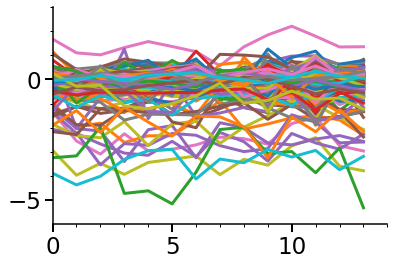

In [161]:
plt.plot(tndata[tndata.obs.condition.isin(['NC'])].X)
plt.xlim(0,14)
plt.ylim(-6,3)
plt.show()

### Sample QC

### Gene QC

### Sample and Gene Filtering

### Batch effect removal 

In [7]:
sc.pp.combat(tndata, key='BioReplicate', covariates=['condition','TimePoint'], inplace=True)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'condition' as categorical
/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'BioReplicate' as categorical
/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new

### Weighted Gene Co-expression Network 
Question: How should we incorporate multiple experimental conditions? Separate graphs for each? 

We define the adjacency matrix as:

$A_{ij} = \mathrm{corr}(g_i,g_j)^\beta $

Here $\beta$ is a soft thresholding parameter to transform the Pearson correlations between gene $i$ and gene $j$ into a directed edge. 

Note that by construction, $A$ already contains self-loops. Don't add another self-loop during training, a typical procedure when training graph convolutional networks.

In [8]:
beta = 37 # This should be an odd number to retain negative weights

if beta % 2 == 0: 
    print('Warning: beta was chosen to be an even integer which is not allowed. please set an odd value. \n The adjacency matrix is not defined.')
else: 
    cor = np.corrcoef(rnadata[rnadata.obs.condition.isin(['NC'])].X.T)
    A = cor ** beta
    A[np.abs(A) <= 10e-4] = 0.0 


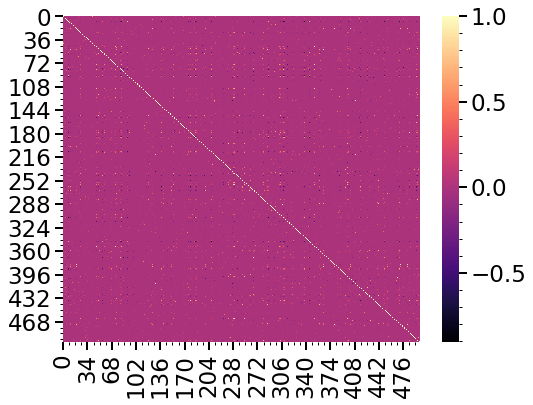

In [9]:
plt.figure(figsize=(8,6))
sns.heatmap(A,cmap='magma')
plt.show()

### Train, val, test split: `data.train_mask`, `data.val_mask`, `data.test_mask`

In [70]:
x_features = tndata[tndata.obs.condition.isin(['NC'])].X.toarray().T
x_features = pd.DataFrame(x_features)

In [71]:
train, validate, test = np.split(x_features.sample(frac=1), 
                            [int(.8*len(x_features)), int(.95*len(x_features))])

In [72]:
train_mask = torch.tensor([True if ii in train.index.tolist() else False for ii in range(len(A))])
val_mask = torch.tensor([True if ii in validate.index.tolist() else False for ii in range(len(A))])
test_mask = torch.tensor([True if ii in test.index.tolist() else False for ii in range(len(A))])

In [73]:
train.shape[0], validate.shape[0], test.shape[0]

(400, 75, 25)

### Graph edges: `data.edge_index` of shape `[2, num_edges]`


In [74]:
adj = torch.tensor(A,dtype=torch.float32)
edge_index = adj.nonzero().t().contiguous()
edge_index.shape

torch.Size([2, 34420])

In [75]:
edge_index

tensor([[  0,   0,   0,  ..., 499, 499, 499],
        [  0,  10,  33,  ..., 435, 461, 499]])

### Graph edge weights: `data.edge_weight` of shape `[num_edges]` 

In [76]:
row1, row2 = edge_index
edge_weight = adj[row1, row2]

### Node feature matrix: `data.x` of shape  `[num_nodes x num_node_features]`
Using condition `NC` at the moment. Still thinking of how to incorporate all the conditions into the node prediction task. What would be useful? 

In [77]:
x = torch.tensor(tndata[tndata.obs.condition.isin(['NC'])].X.copy().T, dtype=torch.float32)
# x_train = x[:,0:7] # BioReplicate 1
# x_test = x[:,7:] # BioReplicate 2

### Graph data class

In [78]:
# data = Data(x=x_train, edge_index=edge_index, num_nodes=len(x), edge_weight=edge_weight)
# data = Data(x=x, edge_index=edge_index, num_nodes=len(x), edge_weight=edge_weight)
data = Data(x=x, edge_index=edge_index, num_nodes=len(x), edge_weight=edge_weight,
           train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

In [79]:
data

Data(x=[500, 14], edge_index=[2, 34420], num_nodes=500, edge_weight=[34420], train_mask=[500], val_mask=[500], test_mask=[500])

### Node targets: `data.y`
As of now, the targets are one-hots corresponding to which gene was knocked down. Though there may be some other more reasonable approach for formulating the targets

In [80]:
a = np.array([ii for ii in range(len(x))])
y = np.zeros((a.size, a.max() + 1))
y[np.arange(a.size), a] = 1
y = y.transpose() # don't actually need to transpose since the target matrix is the identity matrix ( :D )
# y = np.arange(0,data.num_nodes)/(data.num_nodes-1)

In [81]:
data.y = torch.tensor(y,dtype=torch.float32)

### Model architecture

EDGE WEIGHTS CAUSE nans in network output. why? 

In [85]:
class Net(torch.nn.Module):
    def __init__(self,data,num_hops):
        super().__init__()
        self.data = data
        num_classes = data.num_nodes # num classes == number of nodes in graph (likely overconstrained..)
        self.conv1 = SGConv(data.num_features, num_classes, K=num_hops, add_self_loops=False, 
                            cached=True) # cached->what does this do, how does it relate to semi-supervision?
# edge_weight=data.edge_weight,
    def forward(self, x):
        edge_index, edge_weight = data.edge_index, data.edge_weight
        x = self.conv1(x, edge_index) # , edge_weight
        
        return x

In [115]:
num_hops = 4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = Net(data,num_hops).to(device), data.to(device)

torch.manual_seed(100)

optimizer = torch.optim.Adam(model.parameters(), lr=2.0, weight_decay=0.0)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.15, momentum=0.0, dampening=0.0, weight_decay=0.0)
scheduler = ExponentialLR(optimizer, gamma=0.9995)
criterion = nn.CrossEntropyLoss() # computes softmax and then the cross entropy
# criterion = nn.MSELoss()
# criterion = nn.KLDivLoss()

### Model training

In [119]:
acc = {'train':[], 'val':[], 'test':[]}
num_epochs = 10001
for ii, epoch in enumerate(range(1, num_epochs)):
    model.train(True) # for gradient tracking 
    
    optimizer.zero_grad()
    yhat = model(data.x)[data.train_mask]
    loss = criterion(yhat, data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    for params in optimizer.param_groups:
        if params['lr'] >= 0.00001:
            scheduler.step() # update learning rate
    
    model.train(False) # don't need to track gradients for metrics

    if epoch % 10 == 0: 
        corrects = (yhat.argmax(dim=1) == data.y[data.train_mask].argmax(dim=1))
        acc['train'].append( (corrects.sum()/data.y.size(1)).item() )
        corrects = (model(data.x)[data.val_mask].argmax(dim=1) == data.y[data.val_mask].argmax(dim=1))
        acc['val'].append( (corrects.sum()/data.y.size(1)).item() )
        corrects = (model(data.x)[data.test_mask].argmax(dim=1) == data.y[data.test_mask].argmax(dim=1))
        acc['test'].append( (corrects.sum()/data.y.size(1)).item() )
        
    if epoch % 100 == 0: 
        
        print(f'Epoch: {epoch:03d} | LR: {params["lr"]} | Train: {acc["train"][-1]:.4f} | '
              f'Val: {acc["val"][-1]:.4f} | Test: {acc["test"][-1]:.4f}')
    
# plt.plot(train_acc); plt.xlim(-25,num_epochs+25); plt.ylim(-0.01,1.05)
# plt.show()

Epoch: 100 | LR: 0.000950743895272112 | Train: 0.7980 | Val: 0.0000 | Test: 0.0000
Epoch: 200 | LR: 0.0009043642599537146 | Train: 0.7980 | Val: 0.0000 | Test: 0.0000
Epoch: 300 | LR: 0.0008602471377926086 | Train: 0.7980 | Val: 0.0000 | Test: 0.0000
Epoch: 400 | LR: 0.000818282157809122 | Train: 0.7980 | Val: 0.0000 | Test: 0.0000
Epoch: 500 | LR: 0.0007783643331925608 | Train: 0.7980 | Val: 0.0000 | Test: 0.0000
Epoch: 600 | LR: 0.0007403937986481492 | Train: 0.7980 | Val: 0.0000 | Test: 0.0000
Epoch: 700 | LR: 0.0007042755605568326 | Train: 0.7980 | Val: 0.0000 | Test: 0.0000
Epoch: 800 | LR: 0.000669919259322906 | Train: 0.7980 | Val: 0.0000 | Test: 0.0000
Epoch: 900 | LR: 0.0006372389433149085 | Train: 0.7980 | Val: 0.0000 | Test: 0.0000
Epoch: 1000 | LR: 0.0006061528538342418 | Train: 0.7980 | Val: 0.0000 | Test: 0.0000
Epoch: 1100 | LR: 0.0005765832205735504 | Train: 0.7980 | Val: 0.0000 | Test: 0.0000
Epoch: 1200 | LR: 0.0005484560670531434 | Train: 0.7980 | Val: 0.0000 | Test:

Epoch: 9800 | LR: 9.99520868012076e-06 | Train: 0.7980 | Val: 0.0000 | Test: 0.0000
Epoch: 9900 | LR: 9.99520868012076e-06 | Train: 0.7980 | Val: 0.0000 | Test: 0.0000
Epoch: 10000 | LR: 9.99520868012076e-06 | Train: 0.7980 | Val: 0.0000 | Test: 0.0000


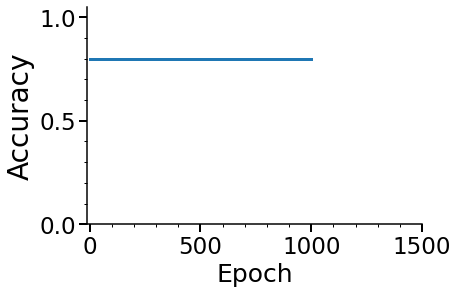

In [120]:
plt.plot(acc['train'])
plt.xlabel('Epoch',fontsize=25); plt.ylabel('Accuracy',fontsize=28)
plt.xlim(-10,)
plt.ylim(-0, 1.05)
plt.show()

In [121]:
print('incorrects')
np.nonzero(yhat.detach().numpy().argmax(axis=1) - np.argmax(y,axis=1))

incorrects


ValueError: operands could not be broadcast together with shapes (400,) (500,) 

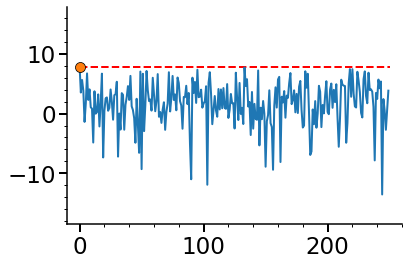

In [775]:
which_gene = 0
plt.plot(yhat.detach()[which_gene,:],lw=2)
plt.plot(which_gene,yhat.detach()[which_gene,which_gene],'o',c='tab:orange',ms=10,mec='k',mew=0.75)
plt.plot([0,data.num_nodes],[yhat.detach()[which_gene,which_gene],yhat.detach()[which_gene,which_gene]],
        c='r',lw=2,linestyle='--',zorder=0)
plt.xlim(-10,data.num_nodes+10)
plt.ylim(yhat.detach()[which_gene,:].min()-5, yhat.detach()[which_gene,:].max()+10)
plt.show()

### Model evaluation

In [794]:
model.eval()
yhat = model(x_train)
yhat_test = model(x_test)

In [788]:
corrects = (yhat_test.argmax(dim=1) == data.y.argmax(dim=1))
test_acc = (corrects.sum()/data.y.size(1)).item()

In [789]:
test_acc

0.03200000151991844

In [ ]:
def test():
    model.eval()
    logits, accs = model(), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

In [801]:
yhat.detach().numpy()

array([[ 1.8290966 ,  0.9839895 ,  1.4159291 , ..., -0.0277667 ,
         0.517612  ,  1.2718053 ],
       [ 1.1511984 ,  2.6071873 ,  0.6875292 , ..., -1.4118302 ,
         1.6807625 ,  0.5421442 ],
       [ 1.5562814 ,  0.8162048 ,  1.7931255 , ...,  1.1869216 ,
        -0.23249531,  1.8133191 ],
       ...,
       [ 1.2162559 ,  0.41630864,  1.9327381 , ...,  3.386847  ,
        -1.8253207 ,  2.04959   ],
       [ 1.3561988 ,  2.3769188 ,  0.31946325, ..., -3.4980457 ,
         3.3524694 , -0.00357043],
       [ 1.5083122 ,  0.80445695,  1.8682001 , ...,  1.4022689 ,
        -0.37352514,  1.9284588 ]], dtype=float32)

### GCNConv

In [284]:
# GCN model with 3 layers 
class Net(torch.nn.Module):
    def __init__(self, n_hidden):
        super(Net, self).__init__()
        num_classes = data.num_nodes
        self.conv1 = GCNConv(data.num_features, n_hidden, add_self_loops=False)
        self.conv2 = GCNConv(n_hidden, n_hidden, add_self_loops=False)
        self.conv3 = GCNConv(n_hidden, int(num_classes), add_self_loops=False)
        # How to include edge weights? 
        
    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = nn.functional.relu(self.conv1(x, edge_index))
        x = nn.functional.dropout(x, training=self.training)
        x = nn.functional.relu(self.conv2(x, edge_index))
        x = nn.functional.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)
        return x

In [285]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_hidden = 250
model, data = Net(num_hidden).to(device), data.to(device)

torch.manual_seed(42)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.0075, weight_decay=0.05)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.1, dampening=0, weight_decay=0.05)
scheduler = ExponentialLR(optimizer, gamma=0.9)
criterion = nn.CrossEntropyLoss() # computes softmax and then the cross entropy

Epoch: 010, Train: 0.0080
Epoch: 020, Train: 0.0120
Epoch: 030, Train: 0.0080
Epoch: 040, Train: 0.0040
Epoch: 050, Train: 0.0040
Epoch: 060, Train: 0.0040
Epoch: 070, Train: 0.0080
Epoch: 080, Train: 0.0120
Epoch: 090, Train: 0.0040
Epoch: 100, Train: 0.0080


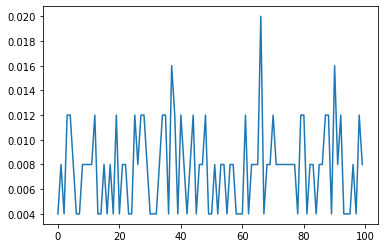

In [286]:
train_acc = []
for ii, epoch in enumerate(range(1, 101)):
    model.train(True) # for gradient tracking 
    
    optimizer.zero_grad()
    yhat = model()
    loss = criterion(yhat, data.y)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    model.train(False) # don't need to track gradients for metrics
    corrects = (yhat.argmax(dim=0) == data.y.argmax(dim=0))
    train_acc.append( (corrects.sum()/data.y.size(1)).item() )
    if epoch % 10 == 0: 
        print(f'Epoch: {epoch:03d}, Train: {train_acc[ii]:.4f}')
    
plt.plot(train_acc)


In [120]:
corrects.sum()

tensor(1)

### Logistic Regression on fitness data to classify gene knockdown

In [122]:
from sklearn.linear_model import LogisticRegression

In [123]:
y_lr = np.arange(0,data.num_nodes)

In [134]:
lr = LogisticRegression(multi_class='multinomial',C=10,solver='sag')
lr = lr.fit(data.x.numpy(), y_lr)

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [135]:
lr.predict(data.x.numpy())

array([233, 261, 156, 141,  51,   5,   6, 310,   8, 173, 333,  11,  12,
        54, 440,  15, 244, 240,  51,  38, 218, 152,  22,  23, 261, 208,
        26,  27,  54,  29,  30, 207,  32, 141,  34, 405, 456,  37,  38,
        39, 184,  41, 392, 440, 471,  45, 316,  10,  48, 240, 427,  51,
       456, 417,  54, 492, 392, 261, 223, 131, 440,  97, 267,  63,  64,
       141,  66,  51,  68, 269, 244, 129, 141,  73, 141,  75,  76, 218,
        78,  79, 384, 261, 392, 383,  84, 275, 445,  84, 141, 240, 432,
        91,  92, 445, 260,  95, 432,  97, 331, 260, 100,  68, 440, 103,
       492, 233, 432, 141, 494, 109, 170, 267, 190,  51, 114, 115, 240,
       392, 118, 292, 440,  45, 207, 203, 124, 285, 126, 127, 141, 173,
       292, 131, 170, 495, 285, 135, 444, 440, 448, 139, 440, 141, 440,
       143, 144, 145,  26, 440, 448, 149, 240, 445, 152,  12, 285, 170,
       310, 157, 218,  63,  54,  27, 162, 163, 392, 190, 166, 440, 440,
        73, 440, 171, 111, 173, 174, 432, 176, 440, 178, 310, 44

In [141]:
len(np.where(lr.predict(data.x.numpy()) - y_lr==0)[0])/500

0.332